# Hierarchical Data Definition

Before starting a model defition process, I final step in preprocessing data is required. As I mentioned several times, I intend to use a hierarchical time series concept to make reliable forecasts. A hierarchical time series is characterized by the ability of disaggregate total values of an item down an hierarchy. In our case, for example, we can make a prediction based on entire New York city to forecast number of metro users. We can disaggregate that into nyc region (Manhattan, Brookly, Bronx, etc.), in finer grains by station and finally, turnstiles.

So here we will transform data properly, visualize this structure and in the end, I need to create a sampling dataset where I am able to fit models in reasonably time.

**Note:** This notebook is strongly based on notebooks I've build for other datasets.

 - [M5 Dataset](https://github.com/vtoliveira/hierarchical-time-series/blob/master/notebooks/02-hierarchical-data-definition.ipynb)
 - [Visnights - Austrlian Tourism](https://github.com/carlomazzaferro/scikit-hts-examples/blob/master/notebooks/visnights.ipynb)

In [1]:
import sys
import os
import gc
import random

sys.path.append("../src")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import cufflinks as cf

cf.go_offline()

from visualize import get_nodes_edges_position, make_annotations

In [2]:
df_turnstiles = pd.read_parquet('../data/preprocessed/turnstiles_daily.parquet.gzip')
df_turnstiles.shape

(12060673, 7)

## Visualizing Hierarchy

Let's start with total node, that would be aggregate number of users for entire new york and regions, as defined in previous notebook.

In [3]:
df_turnstiles.shape

(12060673, 7)

In [4]:
# Getting regions

from common import df_stations_to_regions

df_regions = df_stations_to_regions()

df_turnstiles_reg = (
    df_turnstiles
        .reset_index()
        .merge(df_regions, how='left')
        .set_index(['turnstile', 'time'])
)

del df_turnstiles
gc.collect()

df_turnstiles_reg.shape

(12060673, 8)

In [5]:
# Defining list of tuples as hierarchy

# First level
second_level_nodes = df_turnstiles_reg['region'].dropna().unique().tolist()
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'Manhattan'),
 ('total', 'Brooklyn'),
 ('total', 'Queens'),
 ('total', 'The Bronx')]

Now, for the next level I will use a few stations where I have confidence they do not need to be further aggregated as we saw in eda notebook, that is, they did not change names, or even new turnstiles were created. This will facilitate our jopb in two ways:
 - First, I don't have computation power to fit models using all data.
 - Second, I don't have ways to aggregate data properly withouth talking to someone responsible for this data construction.
 
So, in the end, keep in mind this does not represent entire nyc metro, but reasoning and process will not change. If in the future I can process data in a reliable way, it is just a matter of rerunning future model fitting notebooks.

To get stations that do not change abruptly due some inconsistency with data, we can calculate Year-to-Year metric and drop the ones with high percentage changes between 2013-2016 (Remember that 2017 we only have half of year data).

In [6]:
top_stations = (
    df_turnstiles_reg
        .loc[lambda df: df['region'].notnull()]
        .groupby(['station'])['entries']
        .count()
        .nlargest(20)
        .index
        .tolist()
)

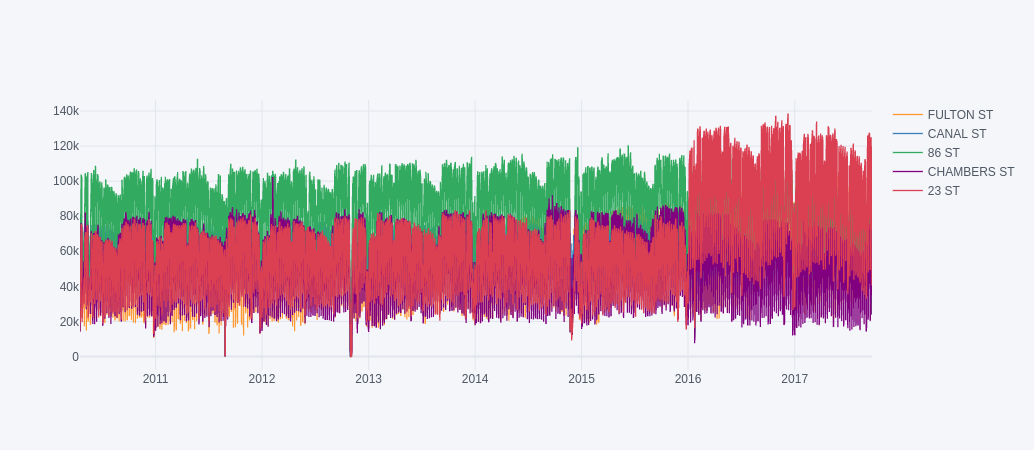

In [7]:
df_station = df_turnstiles_reg.loc[lambda df: df['region'].notnull()].groupby(['station', 'time'])['entries'].sum()
df_station.loc[top_stations[:5]].unstack(level='station').iplot()

In [8]:
df_station_yearly = (
    df_station
        .groupby(['station', pd.Grouper(freq='Y', level='time')])
        .sum()
        .groupby('station')
        .pct_change()
        
)

df_station_yearly.loc[top_stations].unstack(level='station')['2012-12-31':'2016-12-31'].mean(axis=0)

station
FULTON ST         0.072055
CANAL ST         -0.007740
86 ST             0.009342
CHAMBERS ST      -0.000313
23 ST             0.148865
WALL ST           0.006741
125 ST           -0.001754
59 ST             0.058636
14 ST UNION SQ    0.001083
CHURCH AV         0.014216
96 ST             0.012727
50 ST             0.024987
28 ST             0.087579
BOWLING GREEN     0.028396
72 ST             0.008179
JAMAICA 179 ST   -0.004804
QUEENS PLAZA      0.042046
135 ST            0.019522
116 ST            0.016354
33 ST             0.008380
dtype: float64

From table above, *23 ST*, for example, chantged 74% between 2016 and 2015, likely some new station name that should be aggregate to get correct amount. *59 ST*.

As suspected, they do not seem to behave withouth an abrupt change. I just need a sample, I will cut off every station with YoY variation mean betweenb 2012-2016 higher than five percent.

In [9]:
stations_pct_change_mean = df_station_yearly.unstack(level='station')['2012-12-31':'2016-12-31'].mean(axis=0)
stations = stations_pct_change_mean[(stations_pct_change_mean < 0.05) & (stations_pct_change_mean > -0.05)].sample(30, random_state=20).index.tolist()
stations

['PROSPECT PARK',
 'ROCKAWAY BLVD',
 'HUNTS POINT AV',
 'LIBERTY AV',
 'LORIMER ST',
 'STEINWAY ST',
 'ZEREGA AV',
 'SHEEPSHEAD BAY',
 'QUEENS PLAZA',
 'LONGWOOD AV',
 'BAYCHESTER AV',
 'GREENPOINT AV',
 'BEACH 105 ST',
 'BOWERY',
 'UTICA AV',
 'DEKALB AV',
 'FOREST AV',
 'BRONX PARK EAST',
 '167 ST',
 '57 ST',
 '33 ST',
 '53 ST',
 '55 ST',
 'ALABAMA AV',
 'CYPRESS HILLS',
 'CARROLL ST',
 '8 AV',
 '169 ST',
 '219 ST',
 'GRANT AV']

In [10]:
second_to_third = list(df_turnstiles_reg[df_turnstiles_reg['station'].isin(stations)].groupby(['region', 'station']).groups.keys())
second_to_third[:5]

[('Brooklyn', '53 ST'),
 ('Brooklyn', '55 ST'),
 ('Brooklyn', '8 AV'),
 ('Brooklyn', 'ALABAMA AV'),
 ('Brooklyn', 'CARROLL ST')]

In [11]:
root_edges += second_to_third

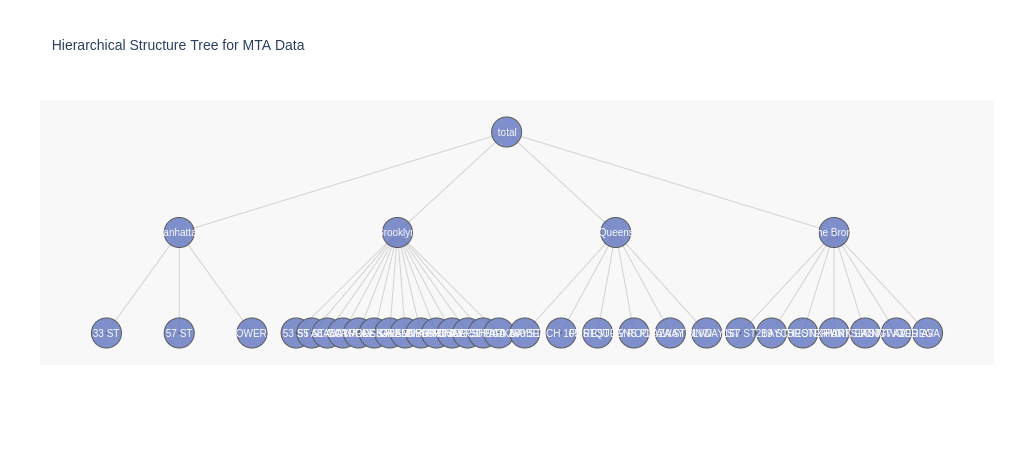

In [12]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for MTA Data',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

Nice! We have then our sampled hierarchy that will simulate MTA complete data where we can work to create models for forecasting purposes and help MTA organization to plan ahead any kind o event, optimal allocating of personal, etc.

In [13]:
df_sampled_data = df_turnstiles_reg.loc[lambda df: df['station'].isin(stations)].reset_index()

df_sampled_data['total'] = 'total'
df_sampled_data["region_state"] = df_sampled_data.apply(lambda x: f"{x['region']}_{x['station']}", axis=1)

In [16]:
df_turnstiles_bottom_level = df_sampled_data.pivot_table(index="time", columns="region_state", values="entries", aggfunc='sum')
df_turnstiles_bottom_level.head(5)

region_state,Brooklyn_53 ST,Brooklyn_55 ST,Brooklyn_8 AV,Brooklyn_ALABAMA AV,Brooklyn_CARROLL ST,Brooklyn_CYPRESS HILLS,Brooklyn_DEKALB AV,Brooklyn_GRANT AV,Brooklyn_GREENPOINT AV,Brooklyn_LIBERTY AV,...,Queens_QUEENS PLAZA,Queens_ROCKAWAY BLVD,Queens_STEINWAY ST,The Bronx_167 ST,The Bronx_219 ST,The Bronx_BAYCHESTER AV,The Bronx_BRONX PARK EAST,The Bronx_HUNTS POINT AV,The Bronx_LONGWOOD AV,The Bronx_ZEREGA AV
time,,,,,,,,,,,,,,,,,,,,,
2010-04-17,3465.0,462.0,13935.0,881.0,3293.0,21.0,10314.0,2665.0,2944.0,1069.0,...,2463.0,2994.0,6320.0,8508.0,1389.0,9.0,1316.0,4232.0,1346.0,934.0
2010-04-18,4328.0,898.0,24283.0,1023.0,4742.0,0.0,13950.0,3036.0,4011.0,1314.0,...,2602.0,3491.0,9448.0,10751.0,1653.0,4.0,1413.0,4880.0,1592.0,1089.0
2010-04-19,6813.0,1768.0,25976.0,2125.0,8825.0,1229.0,24664.0,6182.0,6272.0,2772.0,...,7386.0,7945.0,12490.0,17341.0,3292.0,3489.0,2976.0,10443.0,3094.0,2504.0
2010-04-20,7766.0,2152.0,31378.0,2513.0,10129.0,1499.0,30024.0,6571.0,7475.0,2995.0,...,9829.0,8584.0,14392.0,18909.0,3453.0,4136.0,3202.0,11334.0,3381.0,2734.0
2010-04-21,7796.0,2191.0,33064.0,2472.0,10814.0,1514.0,30497.0,6665.0,7822.0,3167.0,...,10037.0,8285.0,14866.0,18836.0,3327.0,4109.0,3201.0,11272.0,3569.0,2709.0


In [17]:
def get_region_columns(df, region):
    return [col for col in df.columns if region in col]

regions = df_sampled_data["region"].unique().tolist()

for region in regions:
    region_cols = get_region_columns(df_turnstiles_bottom_level, region)
    df_turnstiles_bottom_level[region] = df_turnstiles_bottom_level[region_cols].sum(axis=1)

df_turnstiles_bottom_level["total"] = df_turnstiles_bottom_level[regions].sum(axis=1)

df_turnstiles_bottom_level.head(5)

region_state,Brooklyn_53 ST,Brooklyn_55 ST,Brooklyn_8 AV,Brooklyn_ALABAMA AV,Brooklyn_CARROLL ST,Brooklyn_CYPRESS HILLS,Brooklyn_DEKALB AV,Brooklyn_GRANT AV,Brooklyn_GREENPOINT AV,Brooklyn_LIBERTY AV,...,The Bronx_BAYCHESTER AV,The Bronx_BRONX PARK EAST,The Bronx_HUNTS POINT AV,The Bronx_LONGWOOD AV,The Bronx_ZEREGA AV,Manhattan,Brooklyn,Queens,The Bronx,total
time,,,,,,,,,,,,,,,,,,,,,
2010-04-17,3465.0,462.0,13935.0,881.0,3293.0,21.0,10314.0,2665.0,2944.0,1069.0,...,9.0,1316.0,4232.0,1346.0,934.0,14134.0,59091.0,16682.0,17734.0,107641.0
2010-04-18,4328.0,898.0,24283.0,1023.0,4742.0,0.0,13950.0,3036.0,4011.0,1314.0,...,4.0,1413.0,4880.0,1592.0,1089.0,23345.0,83454.0,21515.0,21382.0,149696.0
2010-04-19,6813.0,1768.0,25976.0,2125.0,8825.0,1229.0,24664.0,6182.0,6272.0,2772.0,...,3489.0,2976.0,10443.0,3094.0,2504.0,32710.0,133197.0,40090.0,43139.0,249136.0
2010-04-20,7766.0,2152.0,31378.0,2513.0,10129.0,1499.0,30024.0,6571.0,7475.0,2995.0,...,4136.0,3202.0,11334.0,3381.0,2734.0,48345.0,153916.0,46121.0,47149.0,295531.0
2010-04-21,7796.0,2191.0,33064.0,2472.0,10814.0,1514.0,30497.0,6665.0,7822.0,3167.0,...,4109.0,3201.0,11272.0,3569.0,2709.0,49104.0,157845.0,46669.0,47023.0,300641.0


Let's plot a path example in your data.

<AxesSubplot:xlabel='time'>

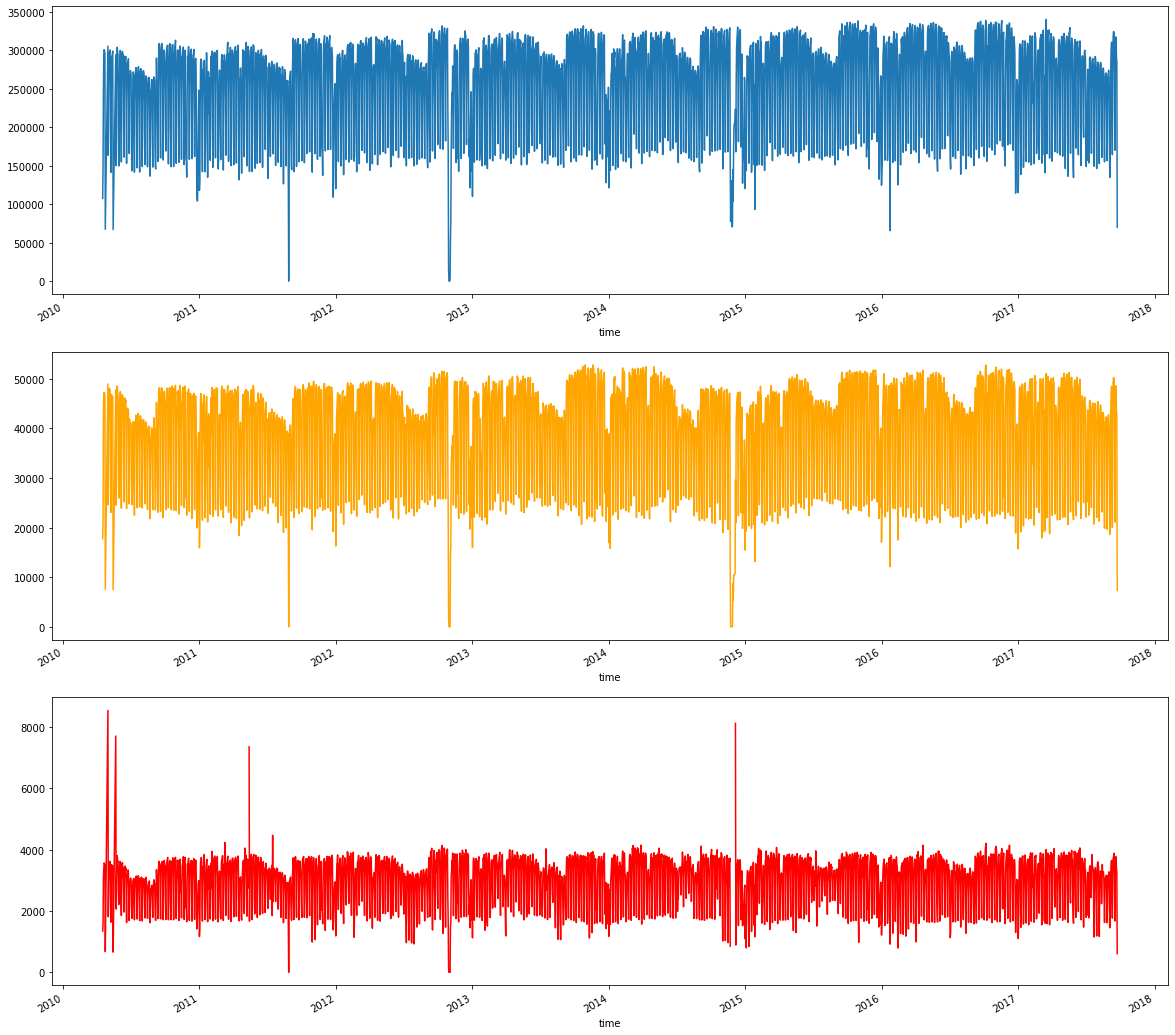

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

df_turnstiles_bottom_level['total'].plot(ax=ax[0])
df_turnstiles_bottom_level['The Bronx'].plot(ax=ax[1], color='orange')
df_turnstiles_bottom_level['The Bronx_LONGWOOD AV'].plot(ax=ax[2], color='red')

In [38]:
df_turnstiles_bottom_level.to_csv('../data/preprocessed/turnstiles_hierarchical_data.csv', index=True)